In [1]:
from pathlib import Path
from typing import Dict

import mre

import mlflow
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2


## helper functions

We only need these once in the experiments, therefore there is no need to add them to `mre`.

In [2]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))

# # code ported from https://github.com/sankalpg/Library_PythonNew
# EPS = np.finfo(np.float).resolution
# def sym_kld(mtx1, mtx2):
#     mtx1 = mtx1 + EPS
#     mtx2 = mtx2 + EPS
#     return mtx1 * np.log(mtx1/mtx2) + mtx2 * np.log(mtx2/mtx1)

In [3]:
def prepare_dataset(
    annotations,
    tdms_files,
    compression_exponent: float = None,  # no compression
    kernel_width: float = None # no smoothing
):
    NUM_BINS = int(1200 / mre.data.TimeDelayedMelodySurface.STEP_SIZE)
    
    num_samples = len(annotations.data)
    num_features = NUM_BINS * NUM_BINS

    # prepare features
    X = np.zeros((num_samples, num_features))
    mbids = np.array([])
    for ii, tf in enumerate(tdms_files):
        tdms = mre.data.TDMSFeature.from_json(tf)
        if compression_exponent is not None:
            tdms.compression_exponent = compression_exponent
            tdms.compress()
        if kernel_width is not None:
            tdms.kernel_width = kernel_width
            tdms.smoothen()
        vals = tdms.embedding

        if vals.size != num_features:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (tf, vals.size, num_features)
            )
        X[ii, :] = vals.reshape(-1)
        mbids = np.append(mbids, Path(tf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return mre.data.dataset.Dataset(X, y)


# Read data

## Annotations

In [4]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Time Delayed Melody Surfaces

Loading is part of the experiment

In [5]:
tdms_runs = mre.mlflow_common.get_runs_with_same_name(
    mre.data.TimeDelayedMelodySurface.EXPERIMENT_NAME,
    mre.data.TimeDelayedMelodySurface.RUN_NAME
)
time_delay_indices = tdms_runs['tags.time_delay_index'].values.astype(float)


# Experimental Setup

In [6]:
ARCHITECTURES = [
#     mre.experimentation.Architecture(  # from yesiler et al
#         name="MultiLayerPerceptron",
#         estimator=MLPClassifier(
#             momentum=0.5,
#             max_iter=10000,
#             learning_rate="adaptive",
#             learning_rate_init=0.001),
#         param_grid={
#             "hidden_layer_sizes": [50, 100],
#             "alpha": [0.01, 0.001]
#         }
#     ),
    mre.experimentation.Architecture(  # from demirel et al
        name="SVM",
        estimator=SVC(kernel="rbf", probability=True),
        param_grid={
            "C": [10, 100, 1000],  # .001, .01, .1, 1, 10 give worse results, omitted
            "gamma": [.1, 1, 10]  # .001, .01, .01 give worse results, omitted
        }
    ),
#     mre.experimentation.Architecture(  # from karakurt et al (morty)
#         name="KNN",
#         estimator=KNeighborsClassifier(),
#         param_grid={
#             "n_neighbors": [1, 3],
#             "weights": ["distance"],  # "uniform" give worse results, omitted 
#             "metric": [bhat, "manhattan"]  # "euclidean" gives worse results, omitted
#         }
#     ),
    mre.experimentation.Architecture(
        name="LogisticRegression",
        estimator=LogisticRegression(max_iter=100, solver="saga"),
        param_grid={
            "penalty": ["l2", 'l1'],
            "C": [0.1, 1, 10]
        }
    ),
# #     mre.experimentation.Architecture(  # overfits heavily, omitted
# #         name="RandomForest",
# #         estimator=RandomForestClassifier(),
# #         param_grid={
# #             "n_estimators": [5, 10, 25, 50],
# #             "criterion": ["gini", "entropy"],
# #             "max_depth": [5, 10, 25, 50]
# #         }
# #     ),
# #     mre.experimentation.Architecture(  # bad overall; commented
# #         name="DecisionTree",
# #         estimator=DecisionTreeClassifier(),
# #         param_grid={
# #             "criterion": ["gini", "entropy"],
# #             "max_depth": [5, 10, 25, 50]
# #         }
# #     ),
]


In [7]:
tdms_param_grid = {
    "compression_exponent": [0.1, 0.25, 0.5, 0.75, 1],
    "kernel_width": [0, 12.5, 25, 50],
}

## Run 10-times shuffle split for each parameter combination


In [8]:
def run_experiment_for_tdms_param(time_delay_index, compression_exponent, kernel_width, num_trials):
    print("==================================================================================================")
    print(f"Running shuffled stratified cross validation experiment with {num_trials} repetitions.")
    print(f"Compression_exponent {compression_exponent}, kernel_width {kernel_width}, time_delay_index {time_delay_index}")
    tdms_files = mre.data.TimeDelayedMelodySurface.from_mlflow(
        time_delay_index=time_delay_index,
        compression_exponent=None,  # used below
        kernel_width=None  # used below
    )

    dataset = prepare_dataset(
        annotations,
        tdms_files,
        compression_exponent=compression_exponent,
        kernel_width=kernel_width
    )
    print(dataset)
    
    stratified_shuffle_cv_experiment = mre.experimentation.StratifiedShuffleCV(
        num_splits=10, num_trials=num_trials
    )

    raw_scores = stratified_shuffle_cv_experiment.run(dataset, ARCHITECTURES)
    # display(stratified_shuffle_cv_experiment.results.head())
    
    _ = stratified_shuffle_cv_experiment.boxplot_best_models()
    plt.show()
    
    print("")
    
    return {
        "compression_exponent": compression_exponent,
        "kernel_width": kernel_width,
        "experiment": stratified_shuffle_cv_experiment,
        "raw_scores": raw_scores,
    }

# Evaluate different shallow architectures under different TDM params

Running shuffled stratified cross validation experiment with 10 repetitions.
Compression_exponent 0.1, kernel_width 0, time_delay_index 1.0
Dataset with 1000 samples and 2304 feature dimensions.
Trial 0
   SVM               , Test acc: 0.34, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.68, Train acc: 1.00∓0.00, Refit time: 52.3 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 1
   SVM               , Test acc: 0.32, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.60, Train acc: 1.00∓0.00, Refit time: 99.3 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 2
   SVM               , Test acc: 0.33, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.68, Train acc: 0.99∓0.00, Refit time: 52.4 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 3
   SVM               , Test acc: 0.37, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.62, Train acc: 1.00∓0.00, Refit time: 52.4 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 4
   SVM               , Test acc: 0.36, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.67, Train acc: 0.99∓0.00, Refit time: 53.5 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 5
   SVM               , Test acc: 0.38, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.79, Train acc: 1.00∓0.00, Refit time: 52.8 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 6
   SVM               , Test acc: 0.27, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.67, Train acc: 1.00∓0.00, Refit time: 52.8 sec, Best Params: {'C': 1, 'penalty': 'l2'}
Trial 7
   SVM               , Test acc: 0.31, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.60, Train acc: 1.00∓0.00, Refit time: 98.5 sec, Best Params: {'C': 10, 'penalty': 'l1'}
Trial 8
   SVM               , Test acc: 0.35, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.64, Train acc: 1.00∓0.00, Refit time: 52.5 sec, Best Params: {'C': 1, 'penalty': 'l2'}
Trial 9
   SVM               , Test acc: 0.30, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.68, Train acc: 1.00∓0.00, Refit time: 52.6 sec, Best Params: {'C': 1, 'penalty': 'l2'}


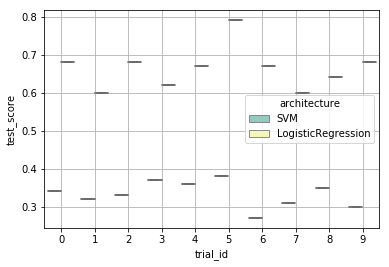

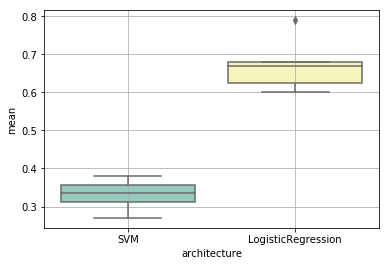


Running shuffled stratified cross validation experiment with 10 repetitions.
Compression_exponent 0.1, kernel_width 0, time_delay_index 0.5
Dataset with 1000 samples and 2304 feature dimensions.
Trial 0
   SVM               , Test acc: 0.31, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.66, Train acc: 1.00∓0.00, Refit time: 53.3 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 1
   SVM               , Test acc: 0.29, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.61, Train acc: 0.99∓0.00, Refit time: 52.0 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 2
   SVM               , Test acc: 0.34, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.65, Train acc: 1.00∓0.00, Refit time: 52.3 sec, Best Params: {'C': 1, 'penalty': 'l2'}
Trial 3
   SVM               , Test acc: 0.33, Train acc: 1.00∓0.00, Refit time: 19.5 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.64, Train acc: 1.00∓0.00, Refit time: 52.3 sec, Best Params: {'C': 10, 'penalty': 'l2'}
Trial 4
   SVM               , Test acc: 0.34, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.68, Train acc: 0.98∓0.00, Refit time: 51.9 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 5
   SVM               , Test acc: 0.42, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.70, Train acc: 1.00∓0.00, Refit time: 52.3 sec, Best Params: {'C': 1, 'penalty': 'l2'}
Trial 6
   SVM               , Test acc: 0.23, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.61, Train acc: 0.99∓0.00, Refit time: 52.3 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 7
   SVM               , Test acc: 0.38, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


   LogisticRegression, Test acc: 0.60, Train acc: 0.99∓0.00, Refit time: 52.3 sec, Best Params: {'C': 0.1, 'penalty': 'l2'}
Trial 8
   SVM               , Test acc: 0.33, Train acc: 1.00∓0.00, Refit time: 19.4 sec, Best Params: {'C': 10, 'gamma': 0.1}


In [ ]:
experiments = []
all_results = pd.DataFrame()
for co in tdms_param_grid["compression_exponent"]:
    for kw in tdms_param_grid["kernel_width"]:
        for tau in time_delay_indices:
            tmp_exp = run_experiment_for_tdms_param(
                time_delay_index=tau,
                compression_exponent=co,
                kernel_width=kw,
                num_trials=10
            )
            tmp_exp["experiment"].results["tdms_compression_exponent"] = tmp_exp['compression_exponent']
            tmp_exp["experiment"].results["tdms_kernel_width"] = tmp_exp['kernel_width']
            tmp_exp["experiment"].results["tdms_time_delay_index"] = tau

            all_results = pd.concat([all_results, tmp_exp["experiment"].results])

            experiments.append(tmp_exp)


### Box plot across experiments

In [ ]:
ax = sns.boxplot(
    x="tdms_kernel_width",
    y="test_score",
    hue="tdms_compression_exponent",
    data=all_results[all_results.architecture=="LogisticRegression"],
    palette="Set3",
)

In [ ]:
ax = sns.boxplot(
    x="tdms_kernel_width",
    y="test_score",
    hue="tdms_compression_exponent",
    data=all_results[all_results.architecture=="SVM"],
    palette="Set3",
)

In [ ]:
stratified_shuffle_cv_experiment.plot_confusion_matrix(architecture="SVM")